<a href="https://colab.research.google.com/github/VSUrhuel/forage-classifier/blob/main/training_without_pre_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from google.colab import drive
import cv2
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
drive.mount('/content/drive')
path_to_dataset = '/content/drive/MyDrive/Thesis/Dataset'

Mounted at /content/drive


In [3]:
classes = ['carabao-grass', 'centro', 'gliricidia', 'leucaena', 'para-grass']

X_train, Y_train = [], []
is_augmented = []
X_val, Y_val = [], []
X_test, Y_test = [], []

def assign_index_label(forage_type):
  forage_type = forage_type.lower()
  if forage_type in classes:
    return classes.index(forage_type)
  else:
    print("Unrecognized forage label")
    return -1

In [4]:
def load_dataset_from_folder(path, X, Y):
  for forage_type in os.listdir(path):
    forage_path = os.path.join(path, forage_type)

    label = assign_index_label(forage_type)
    for image in os.listdir(forage_path):
      image_path = os.path.join(forage_path, image)\

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      image = image / 255.0

      if(image_path.find('aug') != -1):
        is_augmented.append(True)
      else:
        is_augmented.append(False)
      X.append(image)
      Y.append(label)

In [5]:
train_dir = os.path.join(path_to_dataset, 'train')
val_dir = os.path.join(path_to_dataset, 'val')
test_dir = os.path.join(path_to_dataset, 'test')

load_dataset_from_folder(train_dir, X_train, Y_train)
load_dataset_from_folder(val_dir, X_val, Y_val)
load_dataset_from_folder(test_dir, X_test, Y_test)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train, len(classes))
Y_val = to_categorical(Y_val, len(classes))
Y_test = to_categorical(Y_test, len(classes))

In [6]:
# fig, ax = plt.subplots(5, 2, figsize=(15, 15))
# fig.tight_layout()
# selected_indices = []

# for cls in range(len(classes)):
#     # Find all indices where this class appears
#     class_indices = np.where(np.argmax(Y_train, axis=1) == cls)[0]

#     random_idx = random.choice(class_indices)
#     selected_indices.append(random_idx)

# ind = 0
# for i in range(5):
#     for j in range(2):
#       if(ind < len(selected_indices)):
#         continue
#       idx = selected_indices[ind]
#       ax[i, j].imshow(X_train[idx])
#       ax[i, j].set_title(classes[np.argmax(Y_train[idx])])
#       ax[i, j].axis('off')  # Turn off axis for cleaner display
#       ind += 1


# plt.show()

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))


model.add(Dense(5, activation = "softmax"))


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,117,637 (19.52 MB)

 Trainable params: 5,117,637 (19.52 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Thesis/Dataset/best_model.keras',
    save_best_only=True,
    monitor='val_loss'
)


history = model.fit(
    X_train,
    Y_train,
    epochs=80,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping,model_checkpoint]
)

Epoch 1/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 53s 851ms/step - accuracy: 0.2061 - loss: 1.6915 - val_accuracy: 0.4915 - val_loss: 1.4102
Epoch 2/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 767ms/step - accuracy: 0.3472 - loss: 1.4416 - val_accuracy: 0.4746 - val_loss: 1.2619
Epoch 3/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 760ms/step - accuracy: 0.4559 - loss: 1.2513 - val_accuracy: 0.4746 - val_loss: 1.1325
Epoch 4/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 47s 788ms/step - accuracy: 0.4969 - loss: 1.1304 - val_accuracy: 0.5593 - val_loss: 1.0622
Epoch 5/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 757ms/step - accuracy: 0.5465 - loss: 1.0531 - val_accuracy: 0.5593 - val_loss: 0.9657
Epoch 6/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 46s 773ms/step - accuracy: 0.6192 - loss: 0.9224 - val_accuracy: 0.7966 - val_loss: 0.5689
Epoch 7/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 761ms/step - accuracy: 0.7444 - loss: 0.6874 - val_accuracy: 0.8136 - val_loss: 0.4865
Epoch 8/80
59/59 ━━━━━━━━━━━━━━━━━━━━ 45s 763ms/step - accuracy: 0.7557 - loss: 0.6580 - val_accu

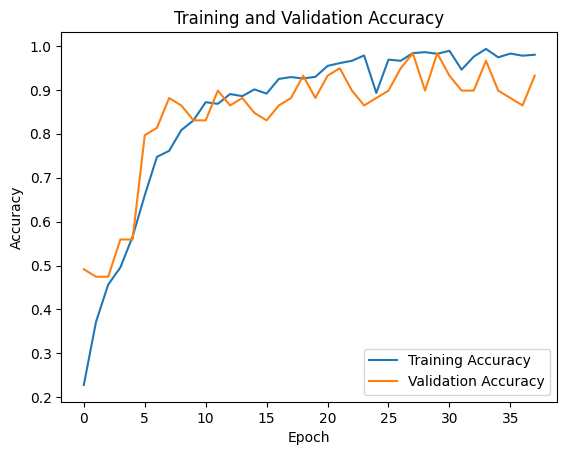

In [10]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

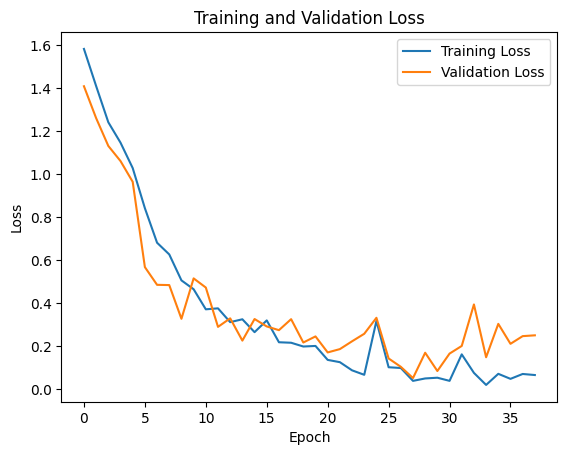

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9887 - loss: 0.0457


In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
val_loss, val_acc = model.evaluate(X_val, Y_val)

In [16]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Thesis/Dataset/best_model.keras')

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Final Test Accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.9245 - loss: 0.8141
Final Test Accuracy: 0.92


In [17]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


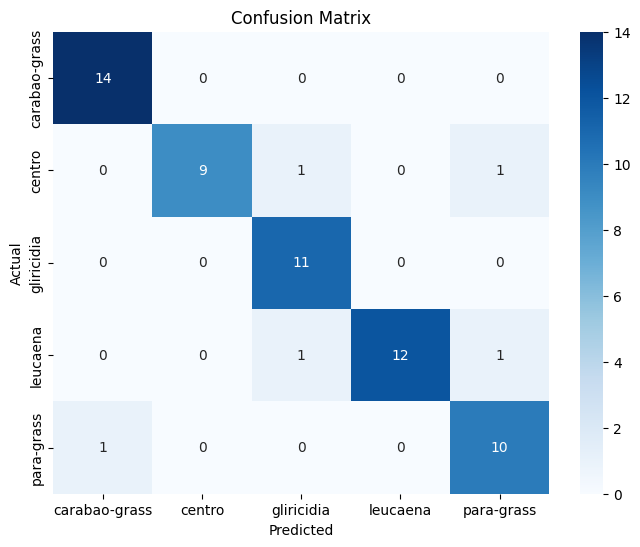

In [18]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
class_report = classification_report(y_true, y_pred_classes, target_names=classes)
print('Classification Report:')
print(class_report)

Classification Report:
               precision    recall  f1-score   support

carabao-grass       0.93      1.00      0.97        14
       centro       1.00      0.82      0.90        11
   gliricidia       0.85      1.00      0.92        11
     leucaena       1.00      0.86      0.92        14
   para-grass       0.83      0.91      0.87        11

     accuracy                           0.92        61
    macro avg       0.92      0.92      0.91        61
 weighted avg       0.93      0.92      0.92        61

